# Phân nhóm quốc gia theo mức phát thải CO₂ (Classification)

Mục tiêu: Tập trung phân loại các quốc gia theo mức phát thải CO₂ trong năm 2023, nhằm tạo một cái nhìn tổng quan về sự phân bố phát thải. Việc phân nhóm giúp nhận diện các quốc gia thuộc nhóm Low, Medium hoặc High, đồng thời làm cơ sở để phân tích các yếu tố kinh tế, dân số và năng lượng ảnh hưởng đến phát thải. 

### Bước 1: Import thư viện

In [50]:
# Import thư viện
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt

### Bước 2: Nhập dữ liệu và lựa chọn dữ liệu cho năm 2023

Mục đích:
Phân nhóm dựa trên lượng phát thải CO₂ năm 2023 để có snapshot cụ thể, tránh sự thay đổi lớn theo thời gian. Nếu dùng nhiều năm, các kỹ thuật supervised learning (Logistic Regression, Decision Tree, Random Forest) sẽ phức tạp hơn, phải xử lý trend và panel data.

In [51]:
# Load dữ liệu
df = pd.read_excel("DataCO2.xlsx")

In [52]:
# Chọn năm 2023
df_2023 = df[df['year'] == 2023].copy()

In [53]:
# Tạo target 3 nhóm theo co2 
# Low: <=33%, Medium: 33-66%, High: >66%
co2_quantiles = df_2023['co2'].quantile([0.33, 0.66])
def co2_group(x):
    if x <= co2_quantiles[0.33]:
        return 0  # Low
    elif x <= co2_quantiles[0.66]:
        return 1  # Medium
    else:
        return 2  # High

df_2023['co2_group'] = df_2023['co2'].apply(co2_group)

In [54]:
# Chọn features 
features = ['gdp','co2_per_gdp','population','co2_per_capita','cement_co2','coal_co2',
            'oil_co2','gas_co2','flaring_co2','land_use_change_co2',
            'primary_energy_consumption','temperature_change_from_co2']

### Bước 3: Chuẩn bị và xử lý dữ liệu

Mục đích:
Chuẩn hóa dữ liệu trước khi đưa vào mô hình machine learning. Đảm bảo không còn NaN gây lỗi, và dữ liệu numeric ở cùng thang đo.

In [55]:
# Kiểm tra thông tin dữ liệu
df_2023.info()
df_2023[features].describe()

<class 'pandas.core.frame.DataFrame'>
Index: 253 entries, 5819 to 6071
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Description                  253 non-null    object 
 1   Name                         253 non-null    object 
 2   year                         253 non-null    int64  
 3   iso_code                     218 non-null    object 
 4   population                   230 non-null    float64
 5   gdp                          0 non-null      float64
 6   co2                          246 non-null    float64
 7   co2_per_capita               181 non-null    float64
 8   co2_per_gdp                  0 non-null      float64
 9   co2_growth_abs               235 non-null    float64
 10  co2_growth_prct              233 non-null    float64
 11  cement_co2                   229 non-null    float64
 12  coal_co2                     157 non-null    float64
 13  flaring_co2          

,gdp,co2_per_gdp,population,co2_per_capita,cement_co2,coal_co2,oil_co2,gas_co2,flaring_co2,land_use_change_co2,primary_energy_consumption,temperature_change_from_co2
count,0.0,0.0,2.300000e+02,181.000000,229.000000,157.000000,233.000000,149.000000,236.000000,214.000000,90.00000,236.000000
mean,NaN,NaN,1.506399e+08,8.274884,30.054961,421.104790,229.718262,254.560946,8.292640,81.762131,7684.98490,0.025665
std,NaN,NaN,7.100382e+08,5.865403,157.719847,1919.033162,1027.098777,884.686696,35.455604,343.232272,23653.51097,0.105105
min,NaN,NaN,5.010000e+02,1.604000,0.000000,0.000000,0.008000,0.000000,0.000000,-296.574000,32.09600,0.000000
25%,NaN,NaN,1.172340e+06,2.169000,0.000000,0.449000,1.232000,1.570000,0.000000,-0.067000,298.34475,0.000000
50%,NaN,NaN,8.062762e+06,8.095000,0.682000,4.123000,7.378000,9.968000,0.000000,1.288500,700.44650,0.001000
75%,NaN,NaN,3.383119e+07,11.092000,3.681000,44.853000,37.210000,82.696000,0.994000,14.408500,2391.98575,0.004000
max,NaN,NaN,8.091735e+09,20.853000,1569.346000,15401.220000,12208.835000,7900.098000,410.940000,3624.905000,172119.06200,1.161000


In [56]:
# Kiểm tra missing values
df_2023.isna().sum()

Description                      0
Name                             0
year                             0
iso_code                        35
population                      23
gdp                            253
co2                              7
co2_per_capita                  72
co2_per_gdp                    253
co2_growth_abs                  18
co2_growth_prct                 20
cement_co2                      24
coal_co2                        96
flaring_co2                     17
gas_co2                        104
land_use_change_co2             39
oil_co2                         20
primary_energy_consumption     163
temperature_change_from_co2     17
co2_group                        0
dtype: int64

In [57]:
# Cập nhật lại danh sách features bỏ biến 'gdp' và 'co2_per_gdp'
features = [
    'population', 'co2_per_capita', 'cement_co2', 'coal_co2', 'oil_co2',
    'gas_co2', 'flaring_co2', 'land_use_change_co2',
    'primary_energy_consumption', 'temperature_change_from_co2'
]

In [58]:
# Define X and y
X = df_2023[features].copy()   # Các biến đầu vào đã chọn
y = df_2023['co2_group']       # 3 nhóm theo co2

In [59]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Bước 4: Xây dựng mô hình và tối ưu tham số

### Nhiệm vụ 1: Mô hình Logistic Regression với GridSearchCV

In [60]:
# Pipeline: Imputer + Scaler + Logistic Regression
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000))
])

param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__solver": ["lbfgs", "liblinear"]
}

grid_lr = GridSearchCV(pipe, param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("=== Logistic Regression ===")
print("Best params:", grid_lr.best_params_)

# Đánh giá mô hình
y_pred_lr = grid_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

=== Logistic Regression ===
Best params: {'model__C': 10, 'model__solver': 'lbfgs'}
Accuracy: 0.6862745098039216

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.69      0.58        16
           1       0.64      0.56      0.60        16
           2       1.00      0.79      0.88        19

    accuracy                           0.69        51
   macro avg       0.71      0.68      0.69        51
weighted avg       0.73      0.69      0.70        51



### Nhiệm vụ 2: Tối ưu tham số cho mô hình cây quyết định bằng GridSearchCV và trực quan hóa hiệu quả mô hình

In [61]:
pipe_dt = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", DecisionTreeClassifier(random_state=42))
])

param_dt = {
    "model__max_depth": [3, 5, 7]
}

grid_dt = GridSearchCV(pipe_dt, param_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)

print("=== Decision Tree ===")
print("Best params:", grid_dt.best_params_)
print("Train CV accuracy:", grid_dt.best_score_)
print("Test accuracy:", grid_dt.score(X_test, y_test))
print(classification_report(y_test, grid_dt.predict(X_test)))

=== Decision Tree ===
Best params: {'model__max_depth': 5}
Train CV accuracy: 0.8962195121951219
Test accuracy: 0.8235294117647058
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        16
           1       0.80      0.75      0.77        16
           2       0.89      0.89      0.89        19

    accuracy                           0.82        51
   macro avg       0.82      0.82      0.82        51
weighted avg       0.82      0.82      0.82        51



 #### Vẽ biểu đồ đánh giá mô hình với các tham số chiều sâu của cây khác nhau

In [62]:
param_grid_dt = {
    'max_depth': [3, 5, 7, 9, None]
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)

grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, None]},
             return_train_score=True, scoring='accuracy')

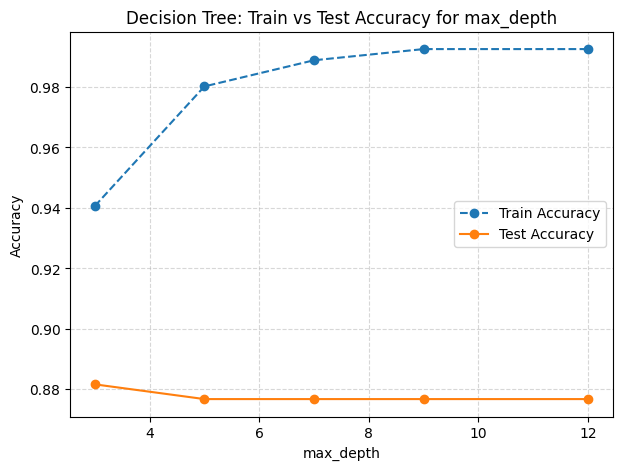

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

results_dt = pd.DataFrame(grid_dt.cv_results_)

# Chuyển None → số để hiển thị rõ trên trục
results_dt['param_max_depth_plot'] = results_dt['param_max_depth'].apply(lambda x: 12 if x is None else x)

plt.figure(figsize=(7,5))
plt.plot(results_dt['param_max_depth_plot'], results_dt['mean_train_score'], marker='o', linestyle='--', label='Train Accuracy')
plt.plot(results_dt['param_max_depth_plot'], results_dt['mean_test_score'], marker='o', linestyle='-', label='Test Accuracy')
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Decision Tree: Train vs Test Accuracy for max_depth")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### Nhiệm vụ 3: Xây dựng rừng cây (random forest)

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [65]:
pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # xử lý missing values
    ('rf', RandomForestClassifier(random_state=42))
])

In [66]:
param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [3, 5, 7, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

In [67]:
grid_rf = GridSearchCV(
    pipeline_rf, param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)

grid_rf.fit(X_train, y_train)

print("=== Random Forest ===")
print("Best params:", grid_rf.best_params_)
print("Best CV Accuracy:", grid_rf.best_score_)

y_pred_rf = grid_rf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_rf)
print("\nTest Accuracy:", test_acc)
print("\nClassification report:\n", classification_report(y_test, y_pred_rf))

=== Random Forest ===
Best params: {'rf__max_depth': 7, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 50}
Best CV Accuracy: 0.9209756097560977

Test Accuracy: 0.9019607843137255

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.88      0.88      0.88        16
           2       0.95      0.95      0.95        19

    accuracy                           0.90        51
   macro avg       0.90      0.90      0.90        51
weighted avg       0.90      0.90      0.90        51



#### Vẽ biểu đồ đánh giá mô hình rừng cây với các tham số số cây có trong rừng khác nhau

In [68]:
# Plot: Fit Time vs n_estimators 
cv_results_df = pd.DataFrame(grid_rf.cv_results_)

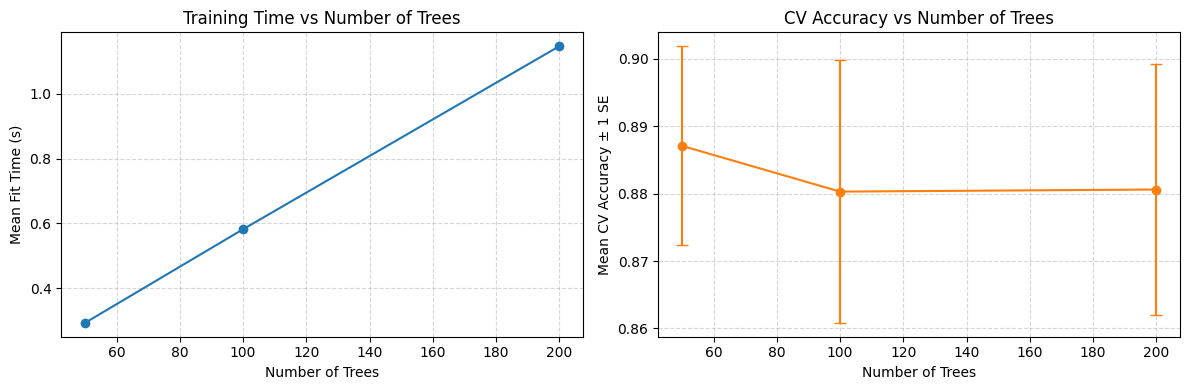

In [69]:
summary = cv_results_df.groupby('param_rf__n_estimators').agg(
    mean_test_score=('mean_test_score', 'mean'),
    std_test_score=('std_test_score', 'mean'),
    mean_fit_time=('mean_fit_time', 'mean')
).reset_index()

fig, axs = plt.subplots(1, 2, figsize=(12,4))

# Màu riêng cho từng biểu đồ
color_fit_time = 'tab:blue'
color_accuracy = 'tab:orange'

# Biểu đồ Training Time
axs[0].plot(
    summary['param_rf__n_estimators'],
    summary['mean_fit_time'],
    '-o',
    color=color_fit_time,
    label='Mean Fit Time'
)
axs[0].set_xlabel('Number of Trees')
axs[0].set_ylabel('Mean Fit Time (s)')
axs[0].set_title('Training Time vs Number of Trees')
axs[0].grid(linestyle='--', alpha=0.5)

# Biểu đồ Accuracy
axs[1].errorbar(
    summary['param_rf__n_estimators'],
    summary['mean_test_score'],
    yerr=summary['std_test_score']/np.sqrt(5),
    fmt='-o',
    capsize=4,
    color=color_accuracy,
    label='Mean CV Accuracy'
)
axs[1].set_xlabel('Number of Trees')
axs[1].set_ylabel('Mean CV Accuracy ± 1 SE')
axs[1].set_title('CV Accuracy vs Number of Trees')
axs[1].grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Bước 5: Xác định các đặc trưng quan trọng (feature importance)
Xem tham số tốt nhất của rừng cây, xem mức độ quan trọng của từng feature trong mô hình với tham số tốt nhất

In [70]:
# Extract best model from pipeline
rf_best = grid_rf.best_estimator_.named_steps['rf']

# Feature Importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_best.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

                       Feature  Importance
4                      oil_co2    0.306662
5                      gas_co2    0.186978
2                   cement_co2    0.158117
9  temperature_change_from_co2    0.101997
3                     coal_co2    0.076968
0                   population    0.066983
7          land_use_change_co2    0.042806
6                  flaring_co2    0.029661
8   primary_energy_consumption    0.021572
1               co2_per_capita    0.008256


In [71]:
# Lấy số lượng feature
n_features = len(feature_importance)

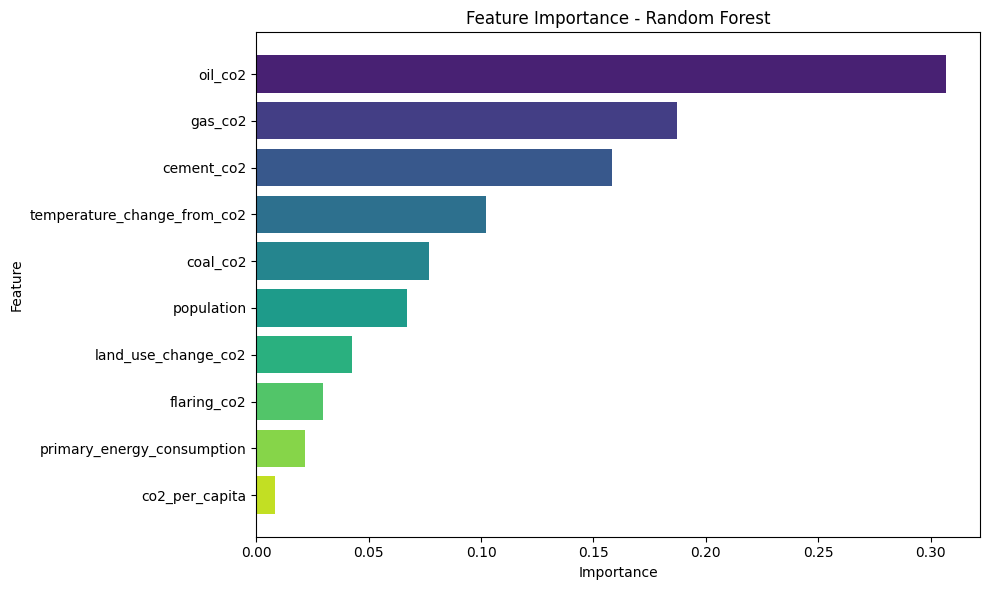

In [72]:
# Tạo màu gradient với seaborn
colors = sns.color_palette("viridis", n_colors=n_features)

# Vẽ biểu đồ nhiều màu
plt.figure(figsize=(10,6))
plt.barh(
    feature_importance['Feature'],
    feature_importance['Importance'],
    color=colors
)
plt.gca().invert_yaxis()  # Biến quan trọng nhất lên trên
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()

# Kết thúc